# Tract clusters using similarity network fusion (SNF)

Here, we test the following hypothesis: 

**White matter tracts are themselves organized in a hierarchical manner, based on their combined surface and white matter features.**

Approach:

* Similarity network fusion (SNF): create tracts x tracts similarity matrices by correlating pairs of tracts in every surface feature. Here, each tract array within a surface map has been “masked”, such that map values of connected regions contain map values, and non-connected regions are assigned to zero. The similarity metric can be cosine similarity (best) or Spearman correlations, i.e. rank transformed to deal with the large amount of zeros. A high correlation between two tracts means that the map values in their respective connected regions were similar. We might want to check here that tracts aren’t simply highly correlated because they literally connect to the same regions (that’s not necessarily a bad thing though, in a way that is also an indication of tract similarity, i.e. tracts likely subserve similar sorts of functions). 
* Can do the same for white matter features, to obtain tract-to-tract similarity across white matter features. 
* Then fuse the similarity matrices together. The fused matrix can then be used to figure out which tracts consistently had similar surface and white matter features, as opposed to tracts with more variable surface features. 
* Apply clustering to identify subgroups of tracts with specific “multimap” profiles, and see if there is a meaningful categorization there. 
* Finally, we can determine which surface maps contributed most to these subtypes. This would tell us whether a group of tracts is more strongly defined by a specific surface map.


In [1]:
# let's import the needed packages
import pandas as pd
import re
from neuromaps.datasets import fetch_fslr, fetch_annotation
from neuromaps import datasets, images, nulls, resampling, stats, transforms, parcellate
from surfplot import Plot
from neuromaps.parcellate import Parcellater, _gifti_to_array
from neuromaps.resampling import resample_images
from neuromaps.images import dlabel_to_gifti
import neuromaps
import nibabel as nib
import os
import numpy as np
import mayavi
from PIL import Image
import hcp_utils as hcp
import nilearn.plotting as plotting
import tractmaps_utils
import matplotlib.pyplot as plt
import seaborn as sns
import snf
from sklearn import cluster
from snf import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from math import pi
import warnings
warnings.filterwarnings('ignore')

/Users/joelleba/opt/anaconda3/envs/tractmaps/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [17]:
# load data for surface features
# tracts_regs_ids = pd.read_csv('./outputs/tracts_regs_Glasser.csv') # tract-to-region csv
# glasser_maps = np.load('./inputs/glasser_maps.npy', allow_pickle = 'True').item() # parcellated surface maps dictionary
# ttests_uniqueness = pd.read_csv('./outputs/ttests_uniqueness/empirical_t_tests.csv') # ttests for tract uniqueness csv
# df_glasser_maps_tracts = pd.read_csv('./outputs/tracts_maps_Glasser.csv')

### Load data

In [26]:
### CORTICAL FEATURES DATA ###
analysis = 'cortex'
data = pd.read_csv('./inputs/tracts_maps_Glasser.csv')
# glasser_maps = np.load('./inputs/glasser_maps.npy', allow_pickle = 'True').item() # load parcellated surface maps dictionary

In [44]:
### NEUROSYNTH DATA ###
analysis = 'neurosynth'
data = pd.read_csv('./inputs/tracts_neurosynth_Glasser.csv')

In [55]:
# set up inputs
connection_threshold = 0.75 # 0.95
ttests_uniqueness = pd.read_csv(f'./outputs/ttests_uniqueness/{analysis}_empirical_t_tests.csv') # ttests for tract uniqueness csv
maps_df = data.iloc[:, 59:]
maps_list = [maps_df[col].values for col in maps_df.columns]
map_names = list(maps_df)
tract_columns = list(data.filter(regex = 'left|right').columns)
glasser_maps = maps_df.to_dict(orient = 'list')
glasser_maps = {key: np.array(value) for key, value in glasser_maps.items()} # store parcellated maps as dictionary of map_names and arrays

### Organize inputs for analyses

In [56]:
## Create long dataframe with map values in all cortical regions, for every tract and every cortical map

# define white matter tracts to loop over 
tracts = data.filter(regex = 'left|right').columns

# Create an empty list to store DataFrames
connected_dfs = []

for index, mp in enumerate(maps_list):

    # map name
    map_name = map_names[index]

    # loop over tracts
    for index, tract in enumerate(tracts):

        # select brain region indices
        tract_regs_idx = data.index[data[f'{tract}'] >= 0.95].tolist()
        
        # select brain region names
        tract_regs_names = data.loc[tract_regs_idx, 'parcel_name'].values
        tract_regs_long_names = data.loc[tract_regs_idx, 'regionLongName'].values
        
        # create array with map values of connected brain regions
        connected = [mp[i] for i in tract_regs_idx]

        # Create a DataFrame for the current array
        current_df = pd.DataFrame({
            'map_name': map_name,
            'tract': tract,
            'parcel_name': tract_regs_names,
            'regionLongName': tract_regs_long_names,
            'map_values': connected
        })

        # Append the current DataFrame to the list
        connected_dfs.append(current_df)


# Concatenate all DataFrames in the list into one
connected_df = pd.concat(connected_dfs, ignore_index = True)
connected_df

,map_name,tract,parcel_name,regionLongName,map_values
0,visual_perception,FAT_left,L_SFL,Superior_Frontal_Language_Area_L,-0.017385
1,visual_perception,FAT_left,L_6ma,Area_6m_anterior_L,-0.109486
2,visual_perception,FAT_left,L_6v,Ventral_Area_6_L,0.039856
3,visual_perception,FAT_left,L_8BL,Area_8B_Lateral_L,-0.064856
4,visual_perception,FAT_left,L_44,Area_44_L,-0.062951
...,...,...,...,...,...
16891,social_cognition,CTh_S_right,R_s6-8,Superior_6-8_Transitional_Area_R,-0.095084
16892,social_cognition,OR_right,R_V1,Primary_Visual_Cortex_R,0.029974
16893,social_cognition,OR_right,R_V2,Second_Visual_Area_R,0.025617
16894,social_cognition,OR_right,R_V3,Third_Visual_Area_R,0.021084


In [57]:
# empty dictionary to store data
brain_map_df_dict = {}
left_brain_map_df_dict = {}
right_brain_map_df_dict = {}

for map_name in map_names:

    # select tract column, brain region ID and brain maps columns
    columns = ['regionID', map_name] + tract_columns
    df = data[columns]

    for tract_column in tract_columns:

        # Create a mask to identify rows where values in the tract column are either NaN or less than threshold
        mask = (df[tract_column].isna()) | (df[tract_column] < connection_threshold)

        # Replace values in the tract column with zeros where the mask is True (NAs or below threshold)
        df[tract_column] = df[tract_column].where(~mask, 0)

        # Replace values in the tract column with values from the brain map column where the mask is False (= connected regions)
        df[tract_column] = df.apply(lambda row: row[map_name] if row[tract_column] != 0 else row[tract_column], axis = 1)

    # drop the brain map column 
    df = df.drop(columns = ['regionID', map_name])

    # flip the dataframe
    df = df.T

    # define left and right dfs
    df_left = df.loc[df.index.str.contains('left')].iloc[:, 0:180]
    df_right = df.loc[df.index.str.contains('right')].iloc[:, 180:360]
   
    # save to dictionaries
    brain_map_df_dict[map_name] = df
    left_brain_map_df_dict[f'L_{map_name}'] = df_left
    right_brain_map_df_dict[f'R_{map_name}'] = df_right

## Similarity Network Fusion

Here, we are leveraging similarity network fusion (SNF) with the goal to capture inter-tract similarity across many cortical map features. Briefly, SNF is an unsupervised computational method that combines many different types of measurements for a given set of samples (e.g. patients, or here tracts). SNF first constructs a sample similarity network for each of the data types and then iteratively integrates these networks using a novel network fusion method.

In our case, instead of creating patients x patients similarity matrices, we will create tracts x tracts similarity matrices. One such matrix will be created for every cortical map. The input to generate the similarity matrix for a given cortical map will be shaped as tracts (rows) x cortical regions (columns). Note that here, map values in brain regions not connected to the tract will be assigned to zero. 

Number of affinity matrices: 32
left hemisphere: 
First clustering option: 5 
Second clustering option: 4
Contribution from each of the individual brain maps to the fused network: 

 [1.         0.62090412 0.62090412 0.62090412 0.62090412 0.62090412
 0.62090412 0.62090412 0.62090412 0.62090412 0.62090412 0.62090412
 0.62090412 0.62090412 0.62090412 0.62090412 0.62090412 0.62090412
 0.62090412 0.62090412 0.62090412 0.62090412 0.62090412 0.65415009
 0.62090412 0.62090412 0.62090412 0.62090412 0.62090412 0.62090412
 0.62090412 0.62090412 0.62090412]

Silhouette score for the fused matrix is: 0.82


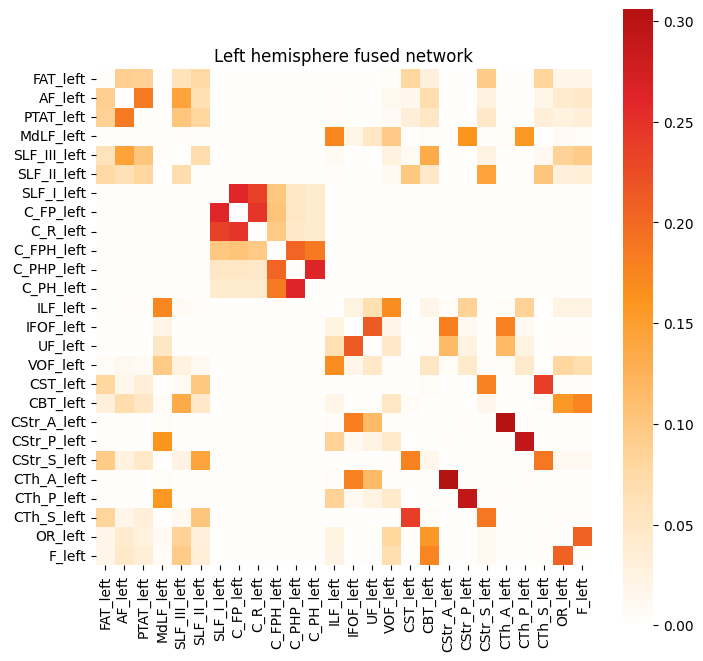

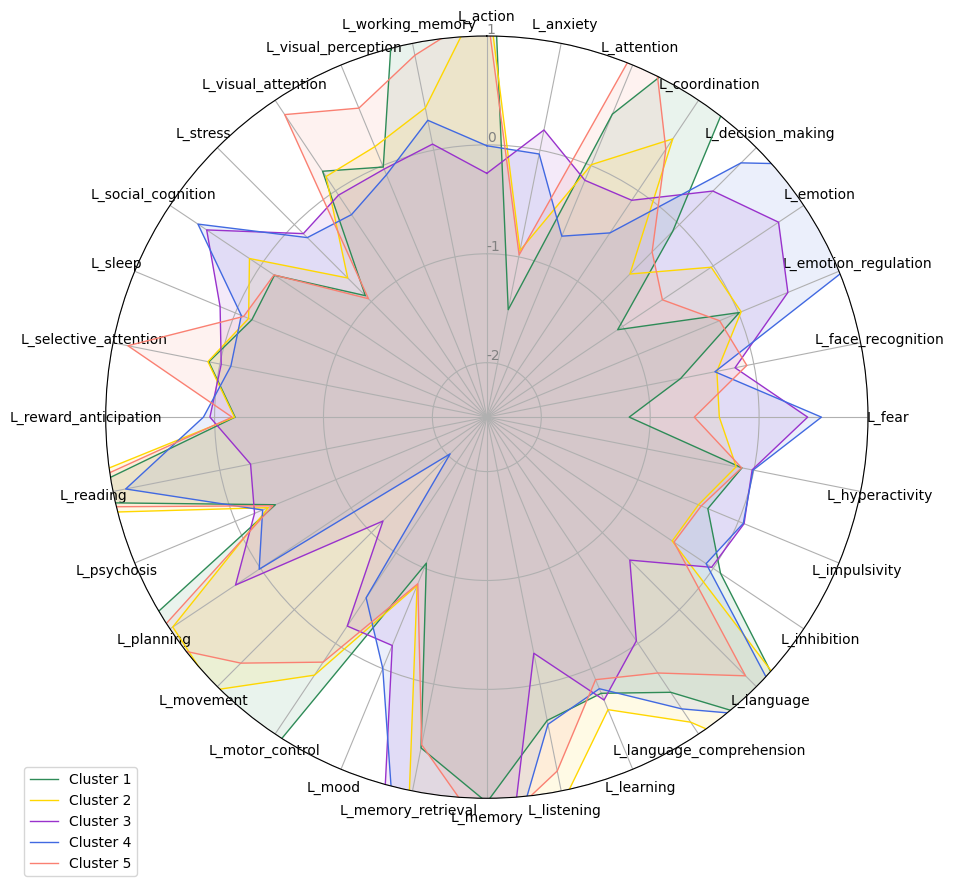

Number of affinity matrices: 32
right hemisphere: 
First clustering option: 5 
Second clustering option: 4
Contribution from each of the individual brain maps to the fused network: 

 [1.         0.55584137 0.55584137 0.55584137 0.55584137 0.55584137
 0.55584137 0.55584137 0.55584137 0.55584137 0.55584137 0.55584137
 0.55584137 0.55584137 0.55584137 0.55584137 0.55584137 0.55584137
 0.55584137 0.55584137 0.55584137 0.55584137 0.53185746 0.55584137
 0.55584137 0.55584137 0.55584137 0.55584137 0.55584137 0.55584137
 0.55584137 0.55584137 0.55584137]

Silhouette score for the fused matrix is: 0.85


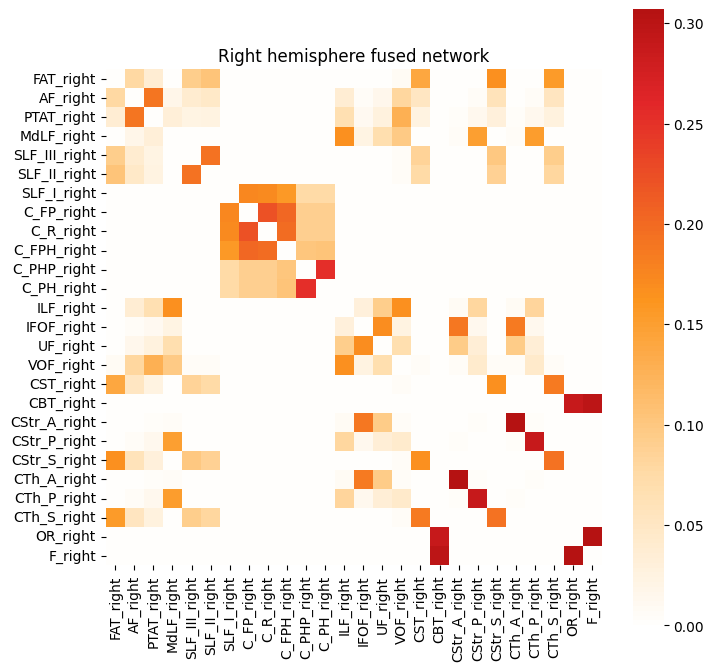

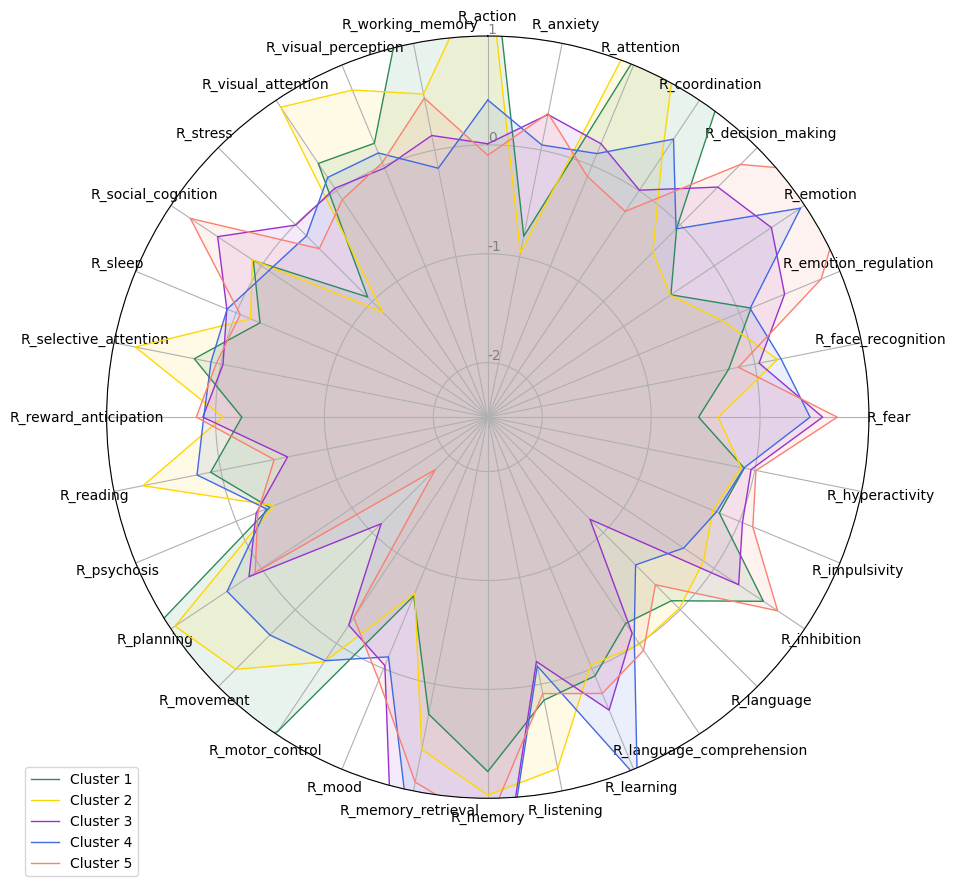

In [58]:
import snf
from sklearn import cluster
from snf import metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from math import pi

# store left and right hemisphere dictionaries in a list
brain_map_df_dicts = [left_brain_map_df_dict, right_brain_map_df_dict]

# empty dictionary to store left and right hemisphere clustering for tracts
tract_clusters_dict = {}

# generate fused matrix for left and right hemisphere separately
for brain_map_df_dict in brain_map_df_dicts:
    
    ### --- GENERATE FUSED NETWORK --- ### 
    
    # transform dictionary values from dataframes to arrays
    brain_map_dict = {key: df.values for key, df in brain_map_df_dict.items()}
    
    # get number of tracts (i.e. N rows in the first array of the dictionary)
    nnodes = next(iter(brain_map_dict.values())).shape[0]

    # generate similarity matrices for every brain map (tracts x tracts)
    affin = snf.compute.make_affinity(list(brain_map_dict.values()),
                                      metric = 'cosine',
                                      K = np.ceil(nnodes/10).astype(int),
                                      mu = 0.5)
    print(f'Number of affinity matrices: {len(affin)}') 

    # generate fused similarity matrix
    fused = snf.compute.snf(affin, K = np.ceil(nnodes/10).astype(int), t = 20, alpha = 1)

    # assign 0 to the diagonal 
    np.fill_diagonal(fused, 0)
    
    #### --- FUSED NETWORK HEATMAP --- ####
    
    # define plot name and plot axis ticks
    if any('L_' in key for key in brain_map_dict.keys()):
        plot_name = 'Left hemisphere fused network'
        hemisphere = 'left'
        hem_tract_columns = list(data.filter(regex = 'left').columns)

    elif any('R_' in key for key in brain_map_dict.keys()):
        plot_name = 'Right hemisphere fused network'
        hemisphere = 'right'
        hem_tract_columns = list(data.filter(regex = 'right').columns)
    
    # plot heatmap
    from matplotlib.colors import ListedColormap
    cmap = np.genfromtxt('./inputs/colourmap.csv', delimiter = ',')
    cmap_seq = ListedColormap(cmap[128:, :])
    plt.figure(figsize=(8, 8))
    sns.heatmap(fused, cmap = cmap_seq,
                square = True, rasterized = True,
                linecolor = 'lightgrey',
                xticklabels = hem_tract_columns, yticklabels = hem_tract_columns)
        
        
    plt.title(plot_name)
    plt.savefig(f'./outputs/snf_clusters/{analysis}_{hemisphere}_thres{connection_threshold}_heatmap_fused.svg')
    
    ### --- CLUSTERING --- ####
    
    # estimate the number of clusters present in the fused matrix, derived via an "eigengap" method (i.e., largest difference in eigenvalues of the
    # laplacian of the graph). Note this function returns the top two options; we'll only use the first
    first, second = snf.compute.get_n_clusters(fused)
    print(f'{hemisphere} hemisphere: \nFirst clustering option: {first} \nSecond clustering option: {second}')

    # apply clustering procedure (since SNF returns an affinity matrix (i.e., all entries are positively-valued and indicate similarity), spectral clustering makes sense)
    fused_labels = cluster.spectral_clustering(fused, n_clusters = first, random_state = 123)

    # create list of labels (for now includes labels generated based on the fused network)
    labels = [fused_labels]
    
    # merge tract labels and clusters (used below to generate brain plots of connected regions in each cluster)
    df_tract_clusters = pd.DataFrame({'clusters': fused_labels, 'tracts': hem_tract_columns})
    tract_clusters_dict[f'{hemisphere}_clusters'] = df_tract_clusters

    # for each affinity matrix, obtain cluster labels and append them to the labels list
    for arr in affin:
        labels += [cluster.spectral_clustering(arr, n_clusters = first)]

    # calculate the normalized mutual information score (NMI) between the labels generated by SNF and the ones obtained on unimodal affinity matrices
    nmi = metrics.nmi(labels)
    print('Contribution from each of the individual brain maps to the fused network: \n\n', nmi[0,:]) # all brain maps contribute quite a bit to the SNF clustering solution

    # compute silhouette score (assesses how well the clusters are defined; -1 indicates a poor clustering solution and 1 indicates a fantastic solution)
    np.fill_diagonal(fused, 0)
    sil = metrics.silhouette_score(fused, fused_labels)
    print('\nSilhouette score for the fused matrix is: {:.2f}'.format(sil)) # the clustering solution is pretty great!
    
    ### --- GENERATE TRACT MEAN Z-SCORES ACROSS MAPS --- ###
    
    # Create an empty DataFrame to store the results
    mean_zcores = pd.DataFrame(columns = ['brain_map', 'clusters', 'mean_zscore'])
    
    for map_name, map_df in brain_map_df_dict.items():

        # get brain map values for tracts in each cluster
        map_df = brain_map_df_dict[map_name].copy()
        map_df.reset_index(inplace = True, names = 'tract_names')
        map_df['clusters'] = fused_labels

        # Select the columns you want to calculate the mean on
        columns_to_mean = map_df.drop(columns = ['tract_names', 'clusters'])

        # Calculate the mean while ignoring zeros
        mean_without_zeros = columns_to_mean[columns_to_mean != 0].mean(axis = 1)

        # Insert the mean back into the original DataFrame
        map_df['mean_zscore'] = mean_without_zeros

        # Group by 'clusters' and calculate the mean within each group
        grouped_mean = map_df.groupby('clusters')['mean_zscore'].mean().reset_index()
        grouped_mean
        # Add the 'brain_map' column
        grouped_mean['brain_map'] = map_name

        # Concatenate the results to the result_df
        mean_zcores = pd.concat([mean_zcores, grouped_mean])

    ### --- SPIDER PLOT --- ###
    
    ### Generate a spider plot showing average z-score per brain map in each cluster ###
    # Based on: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/

    # pivot df to wide for spider plot
    df = mean_zcores.pivot(index = 'clusters', columns = 'brain_map', values = 'mean_zscore').reset_index()
    
    # Create a custom color palette for your clusters
    cluster_colors = ['seagreen', 'gold', 'darkorchid', 'royalblue', 'salmon']

    # -- PART 1: Create background

    # number of variables
    categories = list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (divide the plot by number of variables)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    plt.figure(figsize=(10, 9))
    ax = plt.subplot(111, polar = True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories)

    # Draw ylabels 
    ax.set_rlabel_position(0)
    # lh
#     plt.yticks([-2, -1, 0, 1], ["-2","-1", "0", "1"], color = "grey", size = 10)
#     plt.ylim(-2.5,1.5) # (need to adjust this so it takes max and min of map zscores)
#     # rh 
    plt.yticks([-2, -1, 0, 1], ["-2", "-1", "0", "1"], color = "grey", size = 10)
    plt.ylim(-2.5,1) 

    # -- PART 2: Add plots

    # Plot each cluster = each row in the data
    for i in range(len(df)):
        values = df.loc[i].drop('clusters').values.flatten().tolist()
        values += values[:1]

        color = cluster_colors[i]  # Use custom cluster colors
        label = f"Cluster {i+1}"

        ax.plot(angles, values, linewidth = 1, linestyle = 'solid', label = label, color = color)
        ax.fill(angles, values, color, alpha = 0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.05, 0.05))

    # Save
    plt.tight_layout()
    plt.savefig(f'./outputs/snf_clusters/{analysis}_{hemisphere}_thres{connection_threshold}_clusters_fused.svg', format = 'svg', bbox_inches = 'tight')
    
    # Show plot
    plt.show()
    

#### Visualize all regions connected to tracts of a cluster; show a surface feature that is very different across clusters

In [31]:
import importlib
importlib.reload(tractmaps_utils)

<module 'tractmaps_utils' from '/Users/joelleba/neurohackademy/tractmaps/tractmaps_utils.py'>

Tracts in cluster 1:
 ['MdLF_left', 'ILF_left', 'VOF_left', 'CStr_P_left', 'CTh_P_left', 'OR_left']


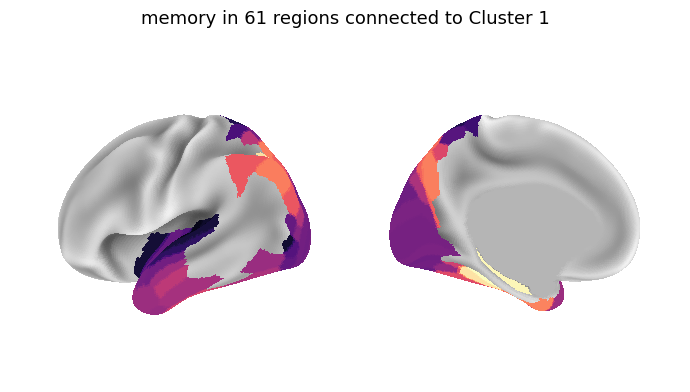

Tracts in cluster 2:
 ['SLF_I_left', 'C_FP_left', 'C_R_left', 'C_FPH_left', 'C_PHP_left', 'C_PH_left']


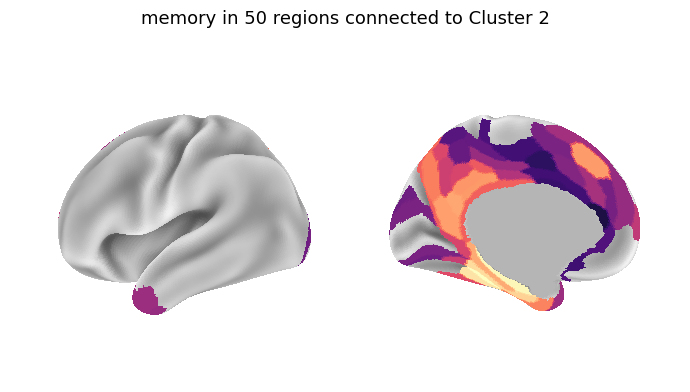

Tracts in cluster 3:
 ['FAT_left', 'AF_left', 'PTAT_left', 'SLF_III_left', 'SLF_II_left', 'CST_left', 'CBT_left', 'CStr_S_left', 'CTh_S_left', 'F_left']


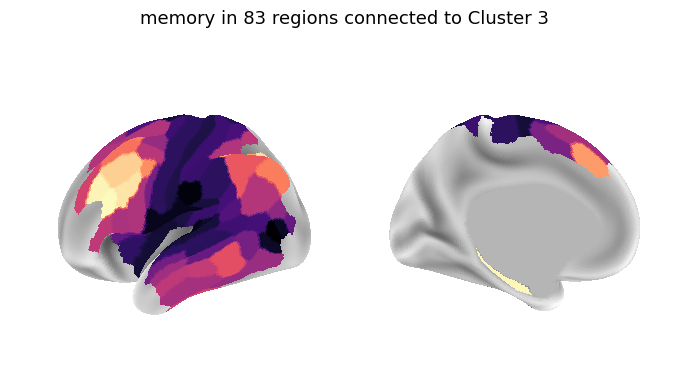

Tracts in cluster 4:
 ['IFOF_left', 'UF_left', 'CStr_A_left', 'CTh_A_left']


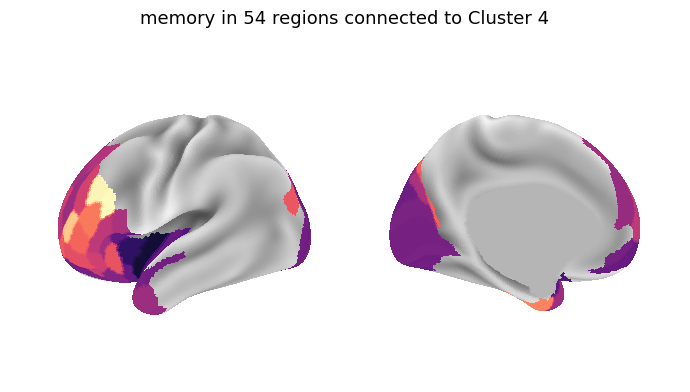

Tracts in cluster 1:
 ['MdLF_right', 'CStr_P_right', 'CTh_P_right']


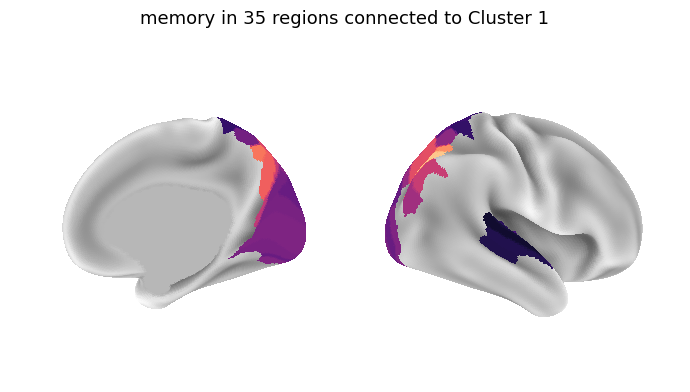

Tracts in cluster 2:
 ['SLF_I_right', 'C_FP_right', 'C_R_right', 'C_FPH_right', 'C_PHP_right', 'C_PH_right']


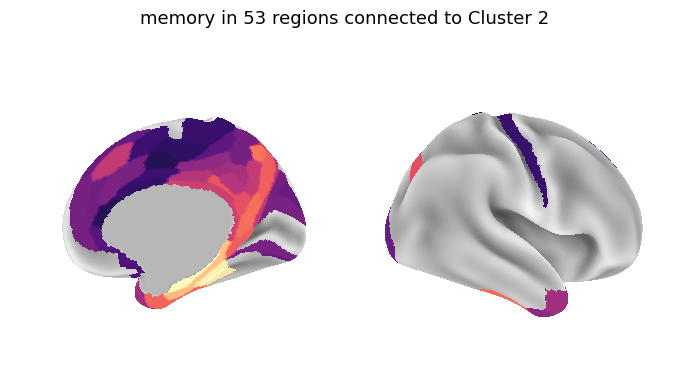

Tracts in cluster 3:
 ['FAT_right', 'AF_right', 'PTAT_right', 'SLF_III_right', 'SLF_II_right', 'CST_right', 'CStr_S_right', 'CTh_S_right']


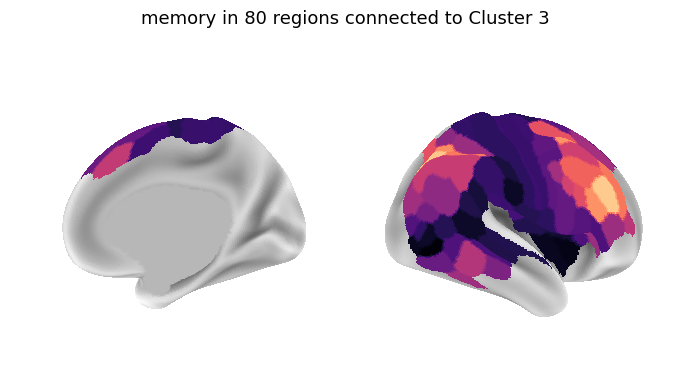

Tracts in cluster 4:
 ['ILF_right', 'IFOF_right', 'UF_right', 'VOF_right', 'CStr_A_right', 'CTh_A_right']


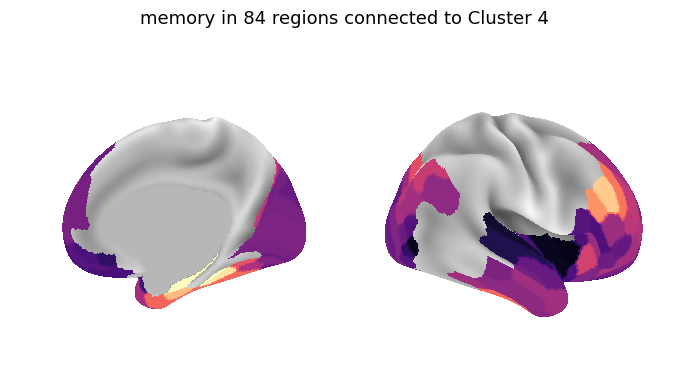

Tracts in cluster 5:
 ['CBT_right', 'OR_right', 'F_right']


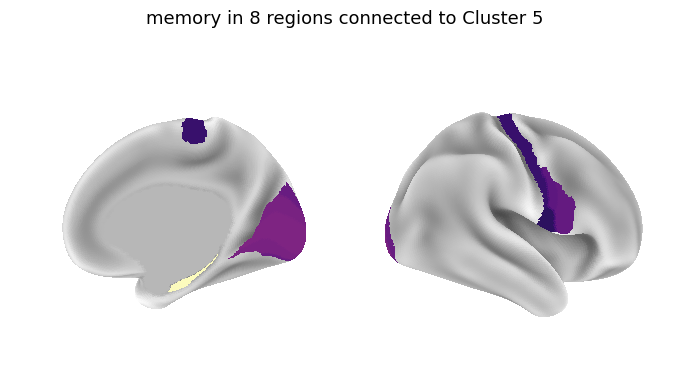

In [54]:
# define map
# mp = 'pet_mglur5_glasser'
# name = 'mGluR5'
mp = 'memory'
name = 'memory'

# for each cluster, select all brain regions that have non-zero values (aka, are connected to a tract)
for tract_clusters_df in tract_clusters_dict.values():
    
    # get tract clusters for the hemisphere
    tracts_by_cluster = tract_clusters_df.groupby('clusters')['tracts'].apply(list).reset_index()

    # generate connected regions plots for each cluster
    for i, tracts in enumerate(tracts_by_cluster['tracts']):
        print(f'Tracts in cluster {i + 1}:\n {tracts}')

        # plot regions connected to the cluster
        tractmaps_utils.plot_parc_subset(brain_map = glasser_maps[mp],
                                        tracts = tracts,
                                        connection_threshold = connection_threshold,
                                        map_name = name,
                                        tract_names = f'Cluster {i + 1}',
                                        colors = 'magma',
                                        mode = 'static')


In [61]:
df

brain_map,clusters,R_areal_scale_glasser,R_cbv_glasser,R_evo_expansion_glasser,R_fc_pc1_glasser,R_genes_glasser,R_glu_metab_glasser,R_myelin_glasser,R_pet_5h14_glasser,R_pet_5ht1a_glasser,R_pet_d1_glasser,R_pet_d2_glasser,R_pet_gaba_glasser,R_pet_mglur5_glasser,R_sa_axis_glasser,R_thickness_glasser
0,0,-0.260597,-0.075875,-0.252227,0.249610,0.129961,0.189728,-0.132301,-0.054254,-0.177115,-0.041063,0.040541,0.176067,-0.307796,0.245744,-0.279376
1,1,0.273521,-0.134412,0.472769,-0.264187,0.198203,0.387547,0.162607,-0.412098,-0.348528,-0.583865,-0.424770,-0.248137,-0.102118,-0.164192,0.030480
2,2,-0.976529,0.368908,-0.603433,-0.428274,0.464079,-0.705211,0.377607,-1.364317,-0.716222,-0.570319,-0.054195,-1.530720,-0.672901,-0.661617,-0.262003
3,3,-0.218143,0.421515,0.393209,0.477041,-0.332271,0.194089,0.251258,-0.156079,-0.281767,0.517379,-0.661282,-0.219875,0.131724,0.156434,0.309421


#### For mean of connected regions

Left hemisphere: 
First clustering option: 4 
Second clustering option: 2
Contribution from each of the individual brain maps to the fused network: 

 [1.]

Silhouette score for the similarity matrix is: 0.55


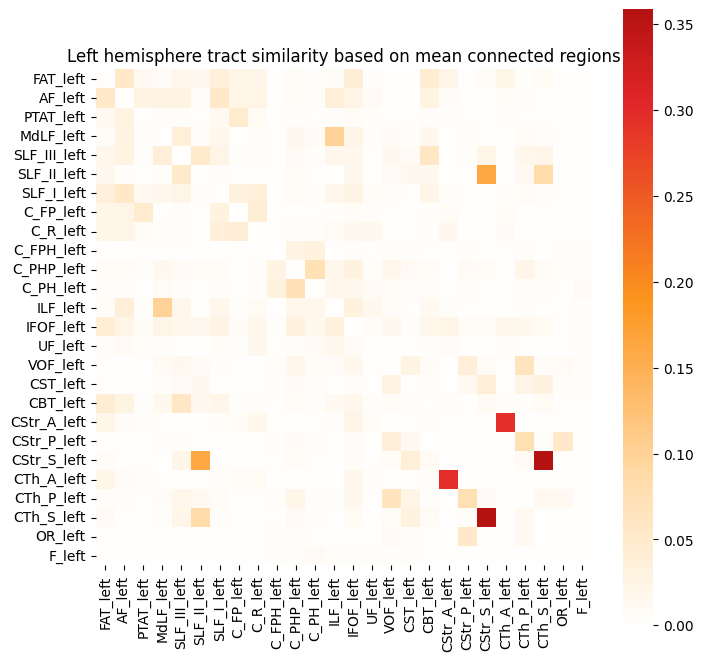

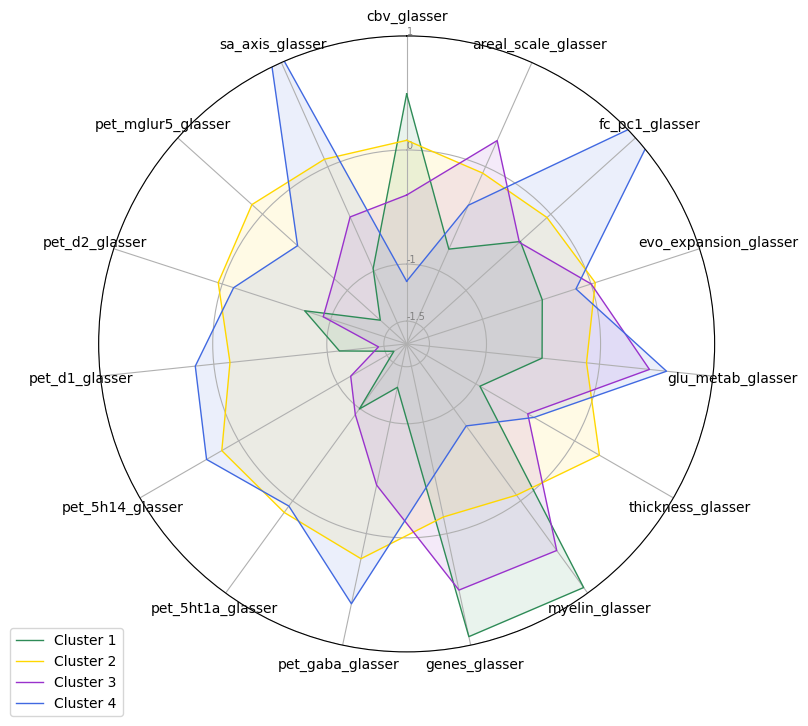

Right hemisphere: 
First clustering option: 5 
Second clustering option: 2
Contribution from each of the individual brain maps to the fused network: 

 [1.]

Silhouette score for the similarity matrix is: 0.65


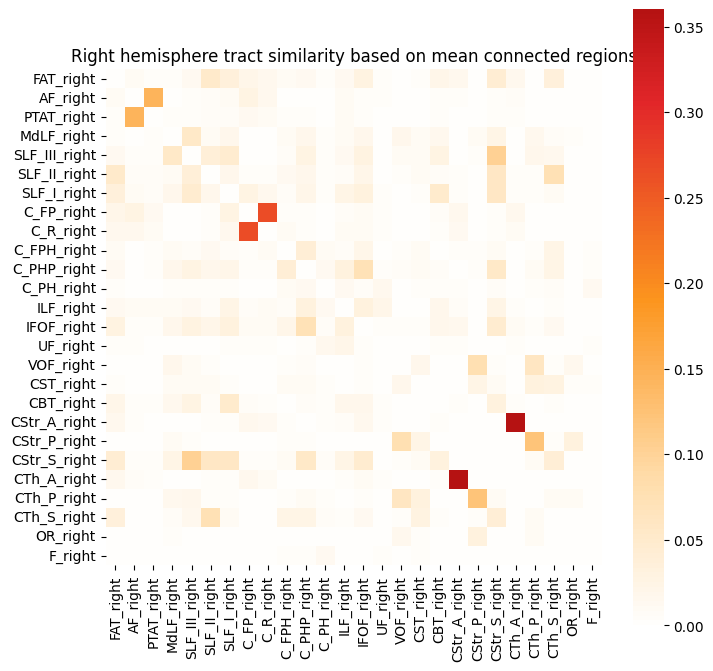

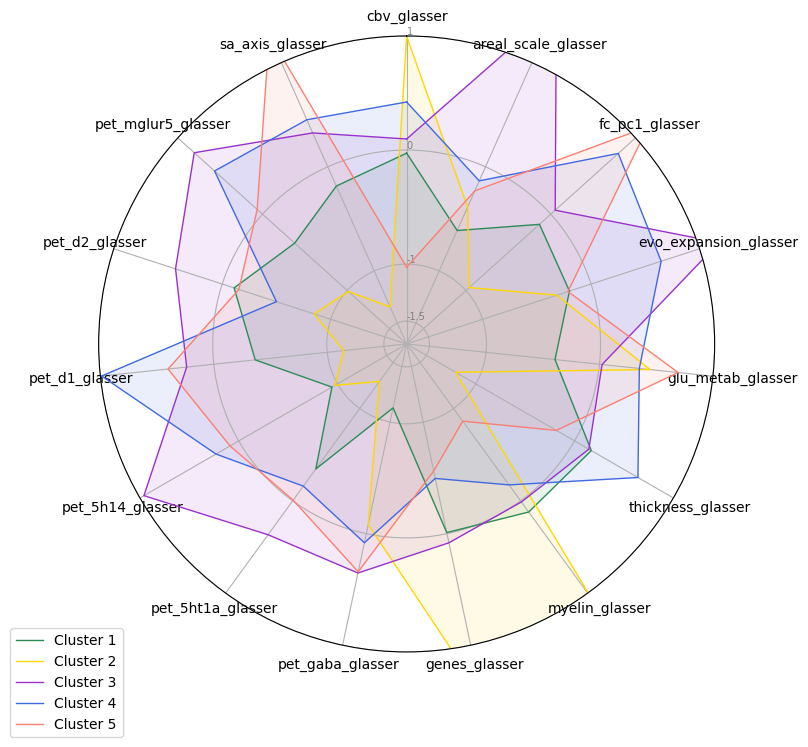

In [29]:
# empty dictionary to store left and right hemisphere clustering for tracts
tract_clusters_dict = {}

# Get cortical maps names
map_names = list(glasser_maps.keys())
tract_names = list(data.filter(regex = 'left|right').columns)

# for each tract 
means_df = pd.DataFrame()
for tract in tract_names:
    
    # select brain regions connected to tract (equal or above connection threshold); select brain map columns
    connected_df = data[data[tract] >= connection_threshold][map_names]
    
    # Calculate the mean by column (brain map)
    connected_means = connected_df.mean(axis = 0)
    
    means_df[tract] = connected_means

means_df = means_df.T

#### --- FUSED NETWORK HEATMAP --- ####

for hemisphere in ['Left', 'Right']:
    
    # define hemisphere data
    if hemisphere == 'Left':
        df = means_df[means_df.index.str.contains('left')]
        plot_name = 'Left hemisphere tract similarity based on mean connected regions'
    elif hemisphere == 'Right':
        df = means_df[means_df.index.str.contains('right')]
        plot_name = 'Right hemisphere tract similarity based on mean connected regions'
        
    # get number of tracts (i.e. N rows in the first array of the dictionary)
    nnodes = df.shape[0]

    # generate similarity matrix for the mean of connected regions (tracts x tracts)
    mean_similarity = snf.compute.make_affinity(df,
                                      metric = 'euclidean',
                                      K = np.ceil(nnodes/10).astype(int),
                                      mu = 0.5)
    # assign 0 to the diagonal 
    np.fill_diagonal(mean_similarity, 0)
    
    # define plot axis ticks
    tracts = list(df.index)
    
    # plot heatmap
    from matplotlib.colors import ListedColormap
    cmap = np.genfromtxt('./inputs/colourmap.csv', delimiter = ',')
    cmap_seq = ListedColormap(cmap[128:, :])
    plt.figure(figsize = (8, 8))
    plt.title(plot_name)
    sns.heatmap(mean_similarity, cmap = cmap_seq,
                square = True, rasterized = True,
                xticklabels = tracts, yticklabels = tracts)
    
    ### --- CLUSTERING --- ####
    
    # estimate the number of clusters present in the fused matrix, derived via an "eigengap" method (i.e., largest difference in eigenvalues of the
    # laplacian of the graph). Note this function returns the top two options; we'll only use the first
    first, second = snf.compute.get_n_clusters(mean_similarity)
    print(f'{hemisphere} hemisphere: \nFirst clustering option: {first} \nSecond clustering option: {second}')

    # apply clustering procedure (since SNF returns an affinity matrix (i.e., all entries are positively-valued and indicate similarity), spectral clustering makes sense)
    sim_labels = cluster.spectral_clustering(mean_similarity, n_clusters = first, random_state = 123)
    
    # create list of labels (for now includes labels generated based on the fused network)
    labels = [sim_labels]
    
    # merge tract labels and clusters (used below to generate brain plots of connected regions in each cluster)
    df_tract_clusters = pd.DataFrame({'clusters': sim_labels, 'tracts': tracts})
    tract_clusters_dict[f'{hemisphere}_clusters'] = df_tract_clusters

    # calculate the normalized mutual information score (NMI) between the labels generated by SNF and the ones obtained on unimodal affinity matrices
    nmi = metrics.nmi(labels)
    print('Contribution from each of the individual brain maps to the fused network: \n\n', nmi[0,:]) # all brain maps contribute quite a bit to the SNF clustering solution

    # compute silhouette score (assesses how well the clusters are defined; -1 indicates a poor clustering solution and 1 indicates a fantastic solution)
    np.fill_diagonal(mean_similarity, 0)
    sil = metrics.silhouette_score(mean_similarity, sim_labels)
    print('\nSilhouette score for the similarity matrix is: {:.2f}'.format(sil)) # the clustering solution is pretty great!
    
    ### --- GENERATE TRACT MEAN Z-SCORES ACROSS MAPS --- ###
    
    # Create an empty DataFrame to store the results
    result_df = pd.DataFrame(columns = ['brain_map', 'clusters', 'mean_zscore'])
    df.reset_index(inplace = True, names = 'tract_names') 
    df['clusters'] = sim_labels

    df = df.loc[:, ~df.columns.isin(['tract_names'])].groupby('clusters').mean()
    df.reset_index(inplace = True, names = 'clusters')

    ### --- SPIDER PLOT --- ###
    
    ### Generate a spider plot showing average z-score per brain map in each cluster ###
    # Based on: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/

    # pivot df to wide for spider plot
#     df = result_df.pivot(index = 'clusters', columns = 'brain_map', values = 'mean_zscore').reset_index()

    # Create a custom color palette for your clusters
    cluster_colors = ['seagreen', 'gold', 'darkorchid', 'royalblue', 'salmon']

    # -- PART 1: Create background

    # number of variables
    categories = list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (divide the plot by number of variables)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, polar = True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axis per variable + add labels
    plt.xticks(angles[:-1], categories)

    # Draw ylabels 
    ax.set_rlabel_position(0)
    plt.yticks([-1.5, -1, 0, 1], ["-1.5","-1", "0", "1"], color = "grey", size = 7)
    plt.ylim(-1.7,1) # (need to adjust this so it takes max and min of map zscores)

    # -- PART 2: Add plots

    # Plot each cluster = each row in the data
    for i in range(len(df)):
        values = df.loc[i].drop('clusters').values.flatten().tolist()
        values += values[:1]

        color = cluster_colors[i]  # Use custom cluster colors
        label = f"Cluster {i+1}"

        ax.plot(angles, values, linewidth = 1, linestyle = 'solid', label = label, color = color)
        ax.fill(angles, values, color, alpha = 0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.05, 0.05))

    # Show the graph
    plt.show()



#### Combined left and right hemispheres

<Axes: >

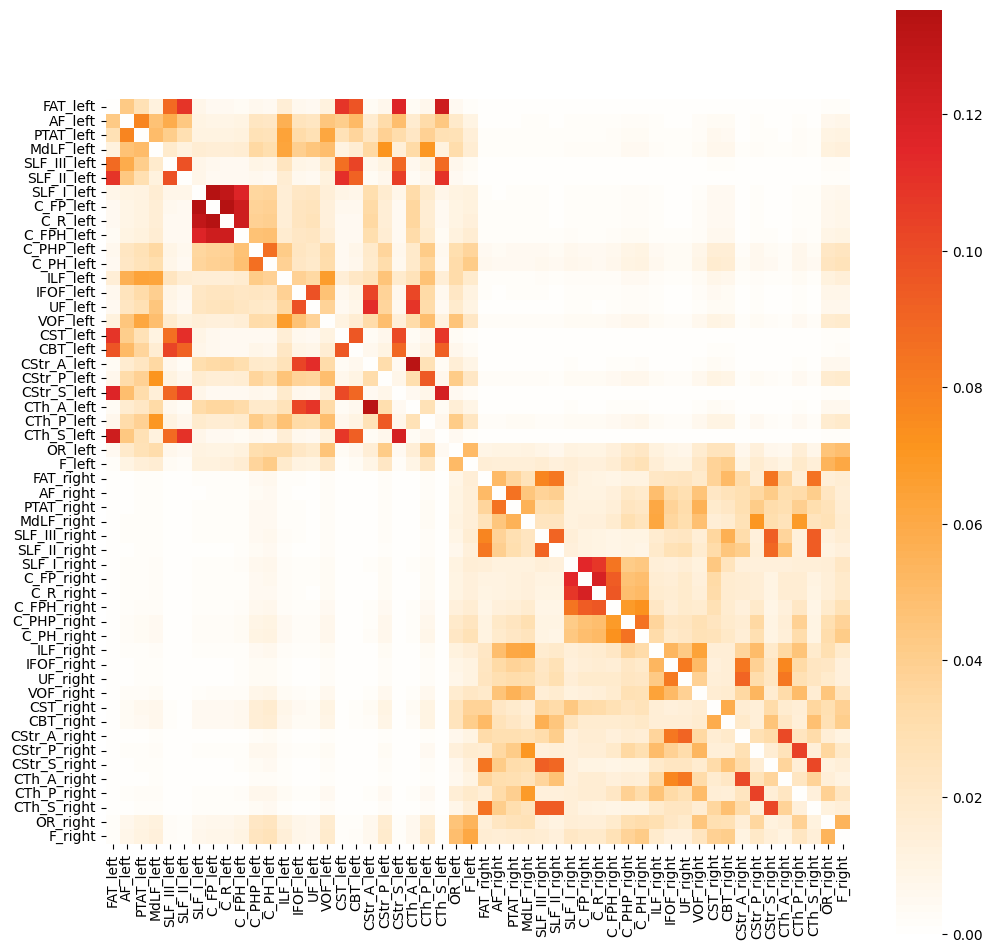

In [49]:
# heatmap
from matplotlib.colors import ListedColormap
cmap = np.genfromtxt('./inputs/colourmap.csv', delimiter = ',')
cmap_seq = ListedColormap(cmap[128:, :])
plt.figure(figsize=(12, 12))
sns.heatmap(fused, cmap = cmap_seq,
            square = True, rasterized = True,
            xticklabels = tract_columns, yticklabels = tract_columns)
# plt.savefig(path+'figures/'+parc+'/heatmap_fused.eps')


##### Violin plot showing full distribution of brain map values in tracts from each cluster

In [227]:
# # Create a list to store the generated plots
# plots = []

# for map_name, map_df in brain_map_df_dict.items():
    
#     # Add clusters to df
#     map_df['clusters'] = fused_labels
   
#     # Melt the dataframe to make it suitable for violin plot
#     df_melted = pd.melt(map_df, id_vars = 'clusters', var_name = 'brain_region', value_name = 'zscore')

#     # Filter out zero values in the "value" column (brain region values)
#     df_melted['zscore'] = df_melted['zscore'].replace(0, pd.NA)
    
#     # Convert the "value" column to numeric to handle NAs
#     df_melted['zscore'] = pd.to_numeric(df_melted['zscore'])
    
#     # Add the brain_map as a new column
#     df_melted['brain_map'] = map_name

# #     filtered_data.append(df_melted)

#     # Create a catplot for the current brain map
#     g = sns.catplot(x='clusters', y='zscore', kind='violin', data=df_melted, palette="Set2")
#     g.fig.suptitle(f"Brain Map: {map_name}", y=1.02)

#     # Add the current plot to the list
#     plots.append(g)

# # Adjust the layout to prevent overlapping titles
# plt.tight_layout()

# # Show the plot
# plt.show()

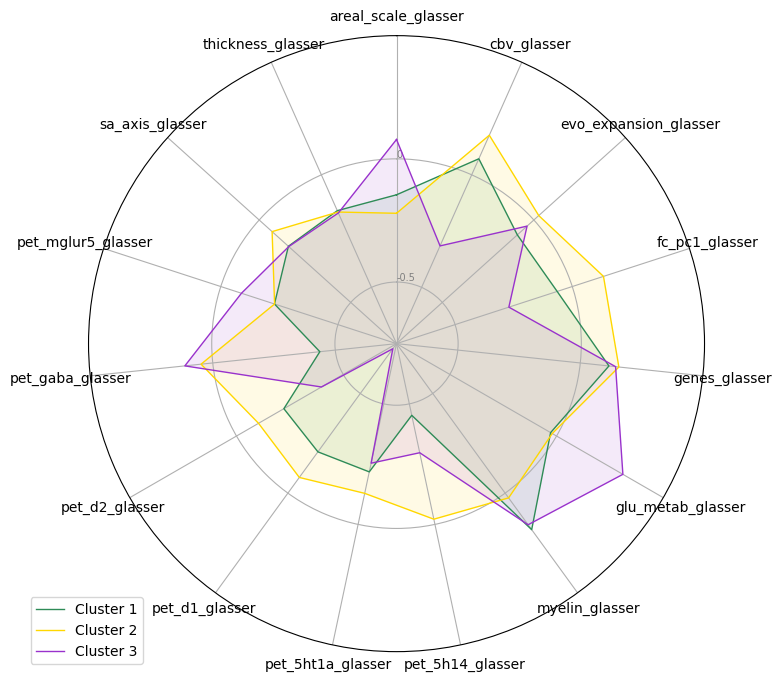

## Other approaches 

This is code for some other approaches, including: 

* Generating a similarity matrix for a single brain map (ex: cortical thickness)
* Spring-embedded representation of a similarity matrix
* Data inputs for dominance analysis (code for that is in `dominance_analysis.py`)

#### Similarity matrix

In [26]:
# # pivot dataframe to wide format
# wide_map_means = ttests_uniqueness.pivot(index = 'map_name', columns = 'tract_name', values = 'connected_mean')

# # generate similarity matrix (correlations) between pairs of tracts across all brain maps (mean values of connected regions)
# correlation_matrix = wide_map_means.corr()

# # Get unique labels
# unique_labels = ttests_uniqueness['tract_name'].unique()

# # Create a DataFrame from the correlation matrix (optional, but can add labels)
# correlation_df = pd.DataFrame(correlation_matrix, columns = unique_labels, index = unique_labels)

# # Create a heatmap
# plt.figure(figsize = (7, 7)) 
# sns.clustermap(correlation_df, cmap = 'coolwarm', linewidths = 0.5, yticklabels = True, xticklabels = True)

# # Set plot title and axis labels (optional)
# plt.title('Correlation Matrix Heatmap')
# plt.xlabel('Labels')
# plt.ylabel('Labels')

# # Show the plot
# plt.show()

#### Spring-embedded representation

This is a spring-embedded representation of the similarities between pairs of tracts across mean values of connected regions in all brain maps. 

In [16]:
# import pandas as pd
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt


# # pivot dataframe to wide format
# wide_map_means = result_df.pivot(index = 'map_name', columns = 'tract_name', values = 'cortical_map_mean')

# # generate similarity matrix (correlations) between pairs of tracts across all brain maps (mean values of connected regions)
# correlation_matrix = wide_map_means.corr()

# # Get unique labels
# unique_labels = result_df['tract_name'].unique()

# # Create a graph
# G = nx.Graph()

# # Add nodes with labels
# for label in unique_labels:
#     G.add_node(label)

# # Compute the number of labels
# n_labels = len(unique_labels)

# # Add weighted edges between labels based on correlation values
# for i in range(n_labels):
#     for j in range(i + 1, n_labels):  # Avoid redundant entries and the diagonal
        
#         label1, label2 = unique_labels[i], unique_labels[j]
#         correlation = correlation_matrix.iloc[i, j]
    
#         if abs(correlation) > 0.8:  # Adjust the threshold as needed
#             G.add_edge(label1, label2, weight=correlation)

# # Use the Spring layout with an adjusted 'k' parameter
# # k_value = 4.0  # Adjust the 'k' parameter to increase or decrease spacing
# # pos = nx.spring_layout(G, k=k_value)
# pos = nx.spring_layout(G)

# # Draw the network
# plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
# nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_color='black')
# plt.axis('off')  # Turn off axis labels
# plt.title('Correlation Network')

# # Show the plot
# plt.show()

# # Set plot title (optional)
# plt.title('Correlation Network')

# # Show the plot
# plt.show()


#### Dominance analysis

In [19]:
# select left hemisphere tracts and brain regions
# left_tract_data = data.filter(regex = 'left').loc[:179]
# # left_tract_data = left_tract_data.iloc[:, :2]
# left_tract_data.to_csv('./inputs/left_tract_data.csv', index = False)

# # select right hemisphere tracts and brain regions
# right_tract_data = data.filter(regex = 'right').loc[180:]
# right_tract_data.to_csv('./inputs/right_tract_data.csv', index = False)

# # select left hemisphere surface maps and brain regions
# left_target_data = data.filter(regex = 'glasser').loc[:179]
# # left_target_data = left_target_data.iloc[:, :2]
# left_target_data.to_csv('./inputs/left_target_data.csv', index = False)

# # select right hemisphere surface maps and brain regions
# right_target_data = data.filter(regex = 'glasser').loc[180:]
# right_target_data.to_csv('./inputs/right_target_data.csv', index = False)

In [20]:
data[data['C_FP_left'] > connection_threshold]

,regionID,parcel_name,FAT_left,AF_left,PTAT_left,MdLF_left,SLF_III_left,SLF_II_left,SLF_I_left,C_FP_left,...,thickness_glasser,myelin_glasser,genes_glasser,pet_gaba_glasser,pet_5ht1a_glasser,pet_5h14_glasser,pet_d1_glasser,pet_d2_glasser,pet_mglur5_glasser,sa_axis_glasser
14,15,L_POS2,0.000000,0.0,0.0,0.097538,0.0,0.0,0.485446,0.976526,...,-0.925577,0.684484,1.236043,0.402363,-1.193099,0.069837,0.150957,-0.404899,0.741715,-0.505284
29,30,L_7m,0.000000,0.0,0.0,0.004735,0.0,0.0,0.933333,0.996244,...,-0.049380,0.244165,0.613934,0.688597,-0.637176,0.802719,1.160220,-0.287047,1.581552,0.170908
30,31,L_POS1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.969953,...,0.476250,0.619341,1.184964,0.696083,-0.955346,0.025756,1.340779,-0.973961,0.072964,-0.241045
32,33,L_v23ab,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.998122,...,0.825815,0.662451,0.467570,0.776608,-0.764546,0.501552,1.461302,-1.022266,0.569329,0.455056
34,35,L_31pv,0.000000,0.0,0.0,0.000000,0.0,0.0,0.502347,0.995305,...,0.099743,0.206017,0.229648,0.405239,-0.300552,0.979083,1.537555,-0.570362,0.956905,0.864174
37,38,L_23c,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.974648,...,-0.310343,-0.561734,-0.114722,-0.239968,0.251146,0.645535,0.802138,-0.797830,0.916675,-0.078137
40,41,L_24dv,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.952113,...,0.189543,-0.437580,-0.923594,-0.350078,0.289431,-0.166635,0.518396,-0.748194,0.653413,-0.329879
56,57,L_p24pr,0.000000,0.0,0.0,0.000000,0.0,0.0,0.994366,0.969953,...,0.687583,-1.261550,-1.086216,0.023410,0.565601,0.590557,1.257444,-0.194417,1.851918,0.245077
58,59,L_a24pr,0.000000,0.0,0.0,0.000000,0.0,0.0,0.969014,0.997183,...,0.807366,-1.544421,-1.622927,0.046090,0.810659,0.426905,0.994130,-0.003316,1.179419,0.436014
59,60,L_p32pr,0.001878,0.0,0.0,0.000000,0.0,0.0,1.000000,0.999061,...,0.817840,-0.726503,-1.222076,0.340411,0.476732,0.103189,0.545931,-0.244579,0.872724,0.442075
